In [1]:
%matplotlib inline

import os
import re
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

Let's first download the Penn Treebank dataset that we will be using for this notebook:

In [2]:
url = "https://raw.githubusercontent.com/jhcross/span-parser/master/data/"
train_file = "02-21.10way.clean"
val_file = "22.auto.clean"
test_file = "23.auto.clean"

print("Downloading data files...")
if not os.path.isfile(train_file):
    urllib.request.urlretrieve(url + train_file, filename=train_file)
if not os.path.isfile(val_file):
    urllib.request.urlretrieve(url + val_file, filename=val_file)
if not os.path.isfile(test_file):
    urllib.request.urlretrieve(url + test_file, filename=test_file)
print("Download complete.")

Download complete.


# Loading the data

In order to work with text data, we need to transform the text into something that our algorithms can work with. The first step of this process is converting words into word ids. We do this by constructing a vocabulary from the data, assigning a new word id to each new word it encounters.

In [3]:
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

"""
    Removes the parse trees in the PTB dataset.
"""
def tokens_from_treestring(s):
    return " ".join(re.findall(r"\([A-Z]* ([^\(\)]+)\)", s))

class Vocabulary:
    
    def __init__(self):
        self.idx_to_word = {0: UNK_TOKEN, 1: PAD_TOKEN, 2: SOS_TOKEN, 3: EOS_TOKEN}
        self.word_to_idx = {UNK_TOKEN: 0, PAD_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
        self.word_freqs = {}
    
    def __getitem__(self, key):
        return self.word_to_idx[key] if key in self.word_to_idx else self.word_to_idx[UNK_TOKEN]
    
    def word(self, idx):
        return self.idx_to_word[idx]
    
    def size(self):
        return len(self.word_to_idx)
    
    @staticmethod
    def from_data(filenames):
        """
            Creates a vocabulary from a list of data files. It assumes that the data files have been
            tokenized and pre-processed beforehand.
        """
        vocab = Vocabulary()
        for filename in filenames:
            with open(filename) as f:
                for line in f:
                    
                    # Strip whitespace and the newline symbol.
                    line = tokens_from_treestring(line.strip())
                    
                    # Split the sentences into words and assign word ids to each
                    # new word it encounters.
                    for word in line.split():
                        if word not in vocab.word_to_idx:
                            idx = len(vocab.word_to_idx)
                            vocab.word_to_idx[word] = idx
                            vocab.idx_to_word[idx] = word
                            
        return vocab

# Construct a vocabulary from the training and validation data.
print("Constructing vocabulary...")
vocab = Vocabulary.from_data([train_file, val_file])
print("Constructed a vocabulary of %d word types" % vocab.size())

Constructing vocabulary...
Constructed a vocabulary of 45233 word types


We also need to load the data files into memory. We create a simple class `TextDataset` that stores the data as a list of sentences:

In [4]:

"""
    A simple class that loads a list of sentences into memory from a text file,
    split by newlines.
"""
class TextDataset(Dataset):
    
    def __init__(self, text_file):
        self.data = []
        with open(text_file) as f:
            for line in f:
                self.data.append(tokens_from_treestring(line.strip()))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Load the training, validation, and test datasets into memory.
train_dataset = TextDataset(train_file)
val_dataset = TextDataset(val_file)
test_dataset = TextDataset(test_file)

# Print some samples from the data:
print("Sample from training data: \"%s\"" % train_dataset[np.random.choice(len(train_dataset))])
print("Sample from validation data: \"%s\"" % val_dataset[np.random.choice(len(val_dataset))])
print("Sample from test data: \"%s\"" % test_dataset[np.random.choice(len(test_dataset))])

Sample from training data: "Nothing less it seemed could console them for traumas"
Sample from validation data: "The bill is aimed at addressing the concern that an airline might sacrifice costly safety measures to pay off the debt incurred in a leveraged buy-out"
Sample from test data: "But these are not the differences that make headlines"


Now it's time to write a function that converts a sentence into a list of word ids using the vocabulary we created before. This function is `create_batch` in the code cell below. This function creates a batch from a list of sentences, and makes sure that each sentence starts with a start-of-sentence symbol and ends with an end-of-sentence symbol. Because not all sentences are of equal length in a certain batch, sentences are padded with padding symbols so that they match the length of the largest sentence in the batch. The function returns an input batch, an output batch, a mask of 1s for words and 0s for padding symbols, and the sequence lengths of each sentence in the batch. The output batch is shifted by one word, to reflect the predictions that the model is expected to make. For example, when an input sentence looks like this:

Input sentence: SOS The dog runs .

the output sentence will look like this:

Output sentence: The dog runs . EOS

Lastly, we create an inverse function `batch_to_sentences` that recovers the list of sentences from a padded batch of word ids to use during test time.

In [5]:
"""
    Converts a list of sentences to a padded batch of word ids. Returns
    an input batch, an output batch shifted by one, a sequence mask over
    the input batch, and a tensor containing the sequence length of each
    batch element.
"""
def create_batch(sentences, vocab, device, word_dropout=0.):
    tok = np.array([[SOS_TOKEN] + sen.split() + [EOS_TOKEN] for sen in sentences])
    seq_lengths = [len(sen)-1 for sen in tok]
    max_len = max(seq_lengths)
    pad_id = vocab[PAD_TOKEN]
    pad_id_input = [
        [vocab[sen[t]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, sen in enumerate(tok)]
    
    # Replace words of the input with <unk> with p = word_dropout.
    if word_dropout > 0.:
        unk_id = vocab[UNK_TOKEN]
        word_drop =  [
            [unk_id if (np.random.random() < word_dropout and t < seq_lengths[idx]) else word_ids[t] for t in range(max_len)] 
                for idx, word_ids in enumerate(pad_id_input)]
    
    # The output batch is shifted by 1.
    pad_id_output = [
        [vocab[sen[t+1]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, sen in enumerate(tok)]
    
    # Convert everything to PyTorch tensors.
    batch_input = torch.tensor(pad_id_input)
    batch_output = torch.tensor(pad_id_output)
    seq_mask = (batch_input != vocab[PAD_TOKEN])
    seq_length = torch.tensor(seq_lengths)
    
    # Move all tensors to the given device.
    batch_input = batch_input.to(device)
    batch_output = batch_output.to(device)
    seq_mask = seq_mask.to(device)
    seq_length = seq_length.to(device)
    
    return batch_input, batch_output, seq_mask, seq_length

"""
    Converts a batch of word ids back to sentences.
"""
def batch_to_sentences(tensors, vocab):
    sentences = []
    batch_size = tensors.size(0)
    for idx in range(batch_size):
        sentence = [vocab.word(t.item()) for t in tensors[idx,:]]
        
        # Filter out the start-of-sentence and padding tokens.
        sentence = list(filter(lambda t: t != PAD_TOKEN and t != SOS_TOKEN, sentence))
        
        # Remove the end-of-sentence token and all tokens following it.
        if EOS_TOKEN in sentence:
            sentence = sentence[:sentence.index(EOS_TOKEN)]
            
        sentences.append(" ".join(sentence))
    return np.array(sentences)

In PyTorch the RNN functions expect inputs to be sorted from long sentences to shorter ones. Therefore we create a simple wrapper class for the DataLoader class that sorts sentences from long to short:  

In [6]:
"""
    A wrapper for the DataLoader class that sorts a list of sentences by their
    lengths in descending order.
"""
class SortingTextDataLoader:

    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.it = iter(dataloader)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        sentences = None
        for s in self.it:
            sentences = s
            break

        if sentences is None:
            self.it = iter(self.dataloader)
            raise StopIteration
        
        sentences = np.array(sentences)
        sort_keys = sorted(range(len(sentences)), 
                           key=lambda idx: len(sentences[idx].split()), 
                           reverse=True)
        sorted_sentences = sentences[sort_keys]
        return sorted_sentences

# The model

\begin{align}
    \log P(x) &= \log \int P(x) p(z) dz \geq\\
    &\geq \mathbb{E}_{q(z|x)}\left[\frac{P(x|z)p(z)}{q(z|x)}\right]\\
    &= \mathbb{E}_{q(z|x)}\left[P(x|z)\right] - \text{KL}\left(q(z|x)||p(z)\right)\\
\end{align}

Let's start with the inference model. The inference model infers a diagonal Gaussian distribution from $x$ with scale $\mu(x)$ and standard deviation $\sigma(x)$.

In [7]:
class InferenceModel(nn.Module):

    def __init__(self, vocab_size, embedder, hidden_size,
                 latent_size, pad_idx, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        
        # We borrow the embedder from the generative model, but we don't
        # want tobackpropagate through it for the inference model. So we
        # need to make sure to call detach on the embeddings later.
        self.embedder = embedder
        
        # Create a (bidirectional) LSTM to encode x.
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, 
                            bidirectional=bidirectional)
        
        # The output of the LSTM doubles if we use a bidirectional encoder.
        encoding_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Create two affine layers to project the encoder final state to
        # the mean and standard deviation of the diagonal Gaussian that
        # we are predicting.
        self.mu_layer = nn.Linear(encoding_size, latent_size)
        self.sigma_layer = nn.Linear(encoding_size, latent_size)

    def forward(self, x, seq_mask, seq_len):
        
        # Compute word embeddings and detach them so that no gradients
        # from the infererence model flow through.
        x_embed = self.embedder(x).detach()
        
        # Encode the sentence using the LSTM.
        hidden = None        
        packed_seq = pack_padded_sequence(x_embed, seq_len, batch_first=True)
        _, final = self.lstm(packed_seq, hidden)        

        # Take the final output h_T from the LSTM, concatenate the forward
        # and backward directions for the bidirectional case.
        h_T = final[0]
        if self.bidirectional:
            h_T_fwd = h_T[0]
            h_T_bwd = h_T[1]
            h_T = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
        
        # Compute the mean and sigma of the diagonal Gaussian distribution.
        # Use a softplus activation for the standard deviation to ensure it's
        # positive.
        mu = self.mu_layer(h_T)
        sigma = F.softplus(self.sigma_layer(h_T))
        
        # Return the inferred Gaussian distribution q(z|x).
        qz = Normal(mu, sigma)
        return qz

Now we define the generative model:

In [8]:
class BowmanLM(nn.Module):
    
    def __init__(self, vocab_size, emb_size, hidden_size, latent_size,
                 pad_idx, dropout=0., bidirectional=False):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedder = nn.Embedding(vocab_size, emb_size,
                                     padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.bridge = nn.Linear(latent_size, hidden_size)
        self.projection = nn.Linear(hidden_size, vocab_size, bias=False)
        self.dropout_layer = nn.Dropout(p=dropout)
        self.inference_model = InferenceModel(vocab_size, self.embedder,
                                              hidden_size, latent_size, pad_idx, 
                                              bidirectional=bidirectional)
    
    """
        Infers the approximate posterior q(z|x) for a given x.
    """
    def infer(self, x, seq_mask, seq_len):
        qz = self.inference_model(x, seq_mask, seq_len)
        return qz

    """
        Returns the hidden state of the LSTM initialized with a projection of a given z.
    """
    def init_hidden(self, z):
        h = self.bridge(z).unsqueeze(0)
        c = self.bridge(z).unsqueeze(0)
        return (h, c)

    """
        Performs a single LSTM step for a given previous word and hidden state.
        Returns the unnormalized probabilities over the vocabulary for this time step. 
    """
    def step(self, prev_x, z, hidden):
        x_embed = self.dropout_layer(self.embedder(prev_x))
        output, hidden = self.lstm(x_embed, hidden)
        scores = self.projection(self.dropout_layer(output))
        return scores, hidden
    
    """
        Performs an entire forward pass given a sequence of words x and a z.
    """
    def forward(self, x, z):
        hidden = self.init_hidden(z)
        outputs = []
        for t in range(x.size(1)):
            prev_x = x[:, t].unsqueeze(-1)
            scores, hidden = self.step(prev_x, z, hidden)
            outputs.append(scores)
        return torch.cat(outputs, dim=1)
        
    """
        Computes the loss given the scores (unnormalized probabilities), targets,
        the prior distribution p(z), and the approximate posterior distribution q(z|x).
        If free_nats is nonzero it will clamp the KL divergence between the posterior
        and prior to that value, preventing gradient propagation via the KL if it's
        below that value. If evaluation is set to true, the loss will be summed instead
        of averaged over the batch. Returns the reconstruction loss and the KL. The loss
        can be computed from those as loss = rec_loss - KL.
    """
    def loss(self, scores, targets, pz, qz, free_nats=0., evaluation=False):
        
        # Approximate E[log P(x|z)].
        scores = scores.permute(0, 2, 1)
        reconstruction_loss = F.cross_entropy(scores, targets, 
                                              ignore_index=self.pad_idx, 
                                              reduction="none")
        reconstruction_loss = reconstruction_loss.sum(dim=1)
        
        # Compute the KL divergence and clamp to at least the given amount of free nats.
        KL = kl_divergence(qz, pz).sum(dim=1)
        KL = torch.clamp(KL, min=free_nats)
        
        # For evaluation return the sum of individual components, for
        # training return the mean of those components.
        if evaluation:
            return (reconstruction_loss.sum(), KL.sum())
        else:
            return (reconstruction_loss.mean(), KL.mean())

# Evaluation metrics

During training we'd like to keep track of some evaluation metrics on the validation data in order to keep track of how our model is doing and to perform early stopping. One simple metric we can compute is the ELBO on all the validation or test data using a single sample from the approximate posterior $q(z|x)$:

In [9]:
"""
    Computes a single sample estimate of the ELBO on a given dataset.
"""
def eval_elbo(model, eval_dataset, vocab, device, batch_size=128):
    dl = DataLoader(eval_dataset, batch_size=batch_size)
    sorted_dl = SortingTextDataLoader(dl)
    
    # Make sure the model is in evaluation mode (i.e. disable dropout).
    model.eval()
            
    total_rec_loss = 0.
    total_KL = 0.
    num_sentences = 0
        
    # We don't need to compute gradients for this.
    with torch.no_grad():
        for sentences in sorted_dl:    
            x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device)
            
            # Infer the approximate posterior and construct the prior.
            qz = model.infer(x_in, seq_mask, seq_len)
            pz = Normal(torch.zeros_like(qz.mean), 
                        torch.ones_like(qz.stddev))
            
            # Compute the unnormalized probabilities using a single sample from the
            # approximate posterior.
            z = qz.sample()
            scores = model(x_in, z)
            
            # Compute the reconstruction loss and KL divergence.
            reconstruction_loss, KL = model.loss(scores, x_out, pz, qz,
                                                 free_nats=0.,
                                                 evaluation=True)
            total_rec_loss += reconstruction_loss
            total_KL += KL
            num_sentences += x_in.size(0)

    # Return the average reconstruction loss and KL.
    avg_rec_loss = total_rec_loss / num_sentences
    avg_KL = total_KL / num_sentences
    return avg_rec_loss, avg_KL

A common metric to evaluate language models is the perplexity per word. The perplexity per word for a dataset is defined as:

\begin{align}
    \text{ppl}(\mathcal{D}) = \exp\left(-\frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}} \sum_{k=1}^{|\mathcal{D}|} \log P(x^{(k)})\right) 
\end{align}

where $n^{(k)}$ is the number of tokens in a sentence and $P(x^{(k)})$ is the probability that our model assigns to the datapoint $x^{(k)}$. In order to compute $\log P(x)$ for our model we need to solve for the integral:

\begin{align}
    P(x) = \int P(x|z) p(z) dz
\end{align}

As this is an integral we cannot compute in closed-form, we have two options: we can use the earlier derived lower-bound on the log-likelihood, which will give us an upper-bound on the perplexity, or we can make an importance sampling estimate using our approximate posterior distribution. The importance sampling estimate can be done as:

\begin{align}
    &\frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}}  \sum_{k=1}^{|\mathcal D|} \log p(x^{(k)}) \\
    &\approx \frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}}  \sum_{k=1}^{|\mathcal D|} \log \frac{1}{S} \sum_{s=1}^{S} \frac{p(z^{(s)})p(x^{(k)}|z^{(s)})}{q(z^{(s)}|x^{(k)})} \\
\end{align}

where $S$ is the number of samples, and $z^{(s)} \sim q(z|x^{k})$. We define the function `eval_perplexity` below that implements this importance sampling estimate:

In [10]:
"""
    Estimates the per-word perplexity using importance sampling with the
    given number of samples.
"""
def eval_perplexity(model, eval_dataset, vocab, device, 
                    n_samples, batch_size=128):
    
    dl = DataLoader(eval_dataset, batch_size=batch_size)
    sorted_dl = SortingTextDataLoader(dl)
    
    # Make sure the model is in evaluation mode (i.e. disable dropout).
    model.eval()
    
    log_px = 0.
    num_predictions = 0
    num_sentences = 0
     
    # We don't need to compute gradients for this.
    with torch.no_grad():
        for sentences in sorted_dl:
            x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device)
            
            # Infer the approximate posterior and construct the prior.
            qz = model.infer(x_in, seq_mask, seq_len)
            pz = Normal(torch.zeros_like(qz.mean), 
                        torch.ones_like(qz.stddev))

            # Create an array to hold all samples for this batch.
            batch_size = x_in.size(0)
            log_px_samples = torch.zeros(n_samples, batch_size)
            
            # Sample log P(x) n_samples times.
            for s in range(n_samples):
                
                # Sample a z^s from the posterior.
                z = qz.sample()
                
                # Compute log P(x^k|z^s)
                scores = model(x_in, z)
                cond_log_prob = F.log_softmax(scores, dim=-1)
                cond_log_prob = torch.gather(cond_log_prob, 2, x_out.unsqueeze(-1)).squeeze() # B x T
                cond_log_prob = (cond_log_prob * seq_mask.type_as(cond_log_prob)).sum(dim=1) # B
                
                # Compute log p(z^s) and log q(z^s|x^k)
                prior_log_prob = pz.log_prob(z).sum(dim=1) # B
                posterior_log_prob = qz.log_prob(z).sum(dim=1) # B
                
                # Store the sample for log P(x^k) importance weighted with p(z^s)/q(z^s|x^k).
                log_px_sample = cond_log_prob + prior_log_prob - posterior_log_prob
                log_px_samples[s] = log_px_sample
                
            # Average over the number of samples and count the number of predictions made this batch.
            log_px_batch = torch.logsumexp(log_px_samples, dim=0) - \
                    torch.log(torch.Tensor([n_samples]))
            log_px += log_px_batch.sum()
            num_predictions += seq_len.sum()
            num_sentences += seq_len.size(0)

    # Compute and return the perplexity per word.
    perplexity = torch.exp(-log_px / num_predictions)
    NLL = -log_px / num_sentences
    return perplexity, NLL

Lastly, we want to occasionally qualitatively see the performance of the model during training, by letting it reconstruct a given sentence from the latent space. This gives us an idea of whether the model is using the latent space to encode some semantics about the data. For this we use a deterministic greedy decoding algorithm, that chooses the word with maximum probability at every time step, and feeds that word into the next time step.

In [11]:
"""
    Greedily decodes a sentence from a given z, by picking the word with
    maximum probability at each time step.
"""
def greedy_decode(model, z, vocab, max_len=50):
    
    # Disable dropout.
    model.eval()
    
    # Don't compute gradients.
    with torch.no_grad():
        batch_size = z.size(0)
        
        # We feed the model the start-of-sentence symbol at the first time step.
        prev_x = torch.ones(batch_size, 1, dtype=torch.long).fill_(vocab[SOS_TOKEN]).to(z.device)
        
        # Initialize the hidden state from z.
        hidden = model.init_hidden(z)

        predictions = []    
        for t in range(max_len):
            scores, hidden = model.step(prev_x, z, hidden)
            
            # Choose the argmax of the unnnormalized probabilities as the
            # prediction for this time step.
            prediction = torch.argmax(scores, dim=-1)
            predictions.append(prediction)
            
            prev_x = prediction.view(batch_size, 1)
            
        return torch.cat(predictions, dim=1)

# Training

Now it's time to train the model. We use early stopping on the validation perplexity for model selection.

In [19]:
# Define the model hyperparameters.
emb_size = 256
hidden_size = 256 
latent_size = 16
bidirectional_encoder = True
free_nats = 5.
annealing_steps = 11400
dropout = 0.6
word_dropout = 0.75
batch_size = 64
learning_rate = 0.001
num_epochs = 20
n_importance_samples = 50
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")   

# Create the training data loader.
dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
sorted_dl = SortingTextDataLoader(dl)

# Create the model.
model = BowmanLM(vocab_size=vocab.size(), 
                  emb_size=emb_size, 
                  hidden_size=hidden_size, 
                  latent_size=latent_size, 
                  pad_idx=vocab[PAD_TOKEN],
                  dropout=dropout,
                  bidirectional=bidirectional_encoder)
model = model.to(device)

# Create the optimizer.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Save the best model (early stopping).
best_model = "./best_model.pt"
best_val_ppl = float("inf")
best_epoch = 0

# Keep track of some statistics to plot later.
train_ELBOs = []
train_KLs = []
val_ELBOs = []
val_KLs = []
val_perplexities = []
val_NLLs = []

step = 0
training_ELBO = 0.
training_KL = 0.
num_batches = 0
for epoch_num in range(1, num_epochs+1):    
    for sentences in sorted_dl:

        # Make sure the model is in training mode (for dropout).
        model.train()

        # Transform the sentences to input, output, seq_len, seq_mask batches.
        x_in, x_out, seq_mask, seq_len = create_batch(sentences, vocab, device,
                                                      word_dropout=word_dropout)

        # Compute the multiplier for the KL term if we do annealing.
        if annealing_steps > 0:
            KL_weight = min(1., (1.0 / annealing_steps) * step)
        else:
            KL_weight = 1.
        
        # Do a forward pass through the model and compute the training loss. We use
        # a reparameterized sample from the approximate posterior during training.
        qz = model.infer(x_in, seq_mask, seq_len)
        pz = Normal(torch.zeros_like(qz.mean), 
                    torch.ones_like(qz.stddev))
        z = qz.rsample()
        scores = model(x_in, z)
        rec_loss, KL = model.loss(scores, x_out, pz, qz, free_nats=free_nats)
        loss = rec_loss + KL_weight * KL

        # Backpropagate and update the model weights.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update some statistics to track for the training loss.
        training_ELBO += -(rec_loss - KL)
        training_KL += KL
        num_batches += 1
        
        # Every 100 steps we evaluate the model and report progress.
        if step % 100 == 0:
            val_rec_loss, val_KL = eval_elbo(model, val_dataset, vocab, device)
            val_ELBO = -(val_rec_loss - val_KL)
            print("(%d) step %d: training ELBO (KL) = %.2f (%.2f) --"
                  " KL weight = %.2f --"
                  " validation ELBO (KL) = %.2f (%.2f)" % 
                  (epoch_num, step, training_ELBO/num_batches, 
                   training_KL/num_batches, KL_weight, val_ELBO, val_KL))
            
            # Update some statistics for plotting later.
            train_ELBOs.append((step, (training_ELBO/num_batches).item()))
            train_KLs.append((step, (training_KL/num_batches).item()))
            val_ELBOs.append((step, val_ELBO.item()))
            val_KLs.append((step, val_KL.item()))
            
            # Reset the training statistics.
            training_ELBO = 0.
            training_KL = 0.
            num_batches = 0
            
        step += 1

    # After an epoch we'll compute validation perplexity and save the model
    # for early stopping if it's better than previous models.
    print("Finished epoch %d" % (epoch_num))
    val_perplexity, val_NLL = eval_perplexity(model, val_dataset, vocab, device, 
                                              n_importance_samples)
    val_rec_loss, val_KL = eval_elbo(model, val_dataset, vocab, device)
    val_ELBO = -(val_rec_loss - val_KL)
    
    # Keep track of the validation perplexities / NLL.
    val_perplexities.append((epoch_num, val_perplexity.item()))
    val_NLLs.append((epoch_num, val_NLL.item()))
    
    # If validation perplexity is better, store this model for early stopping.
    if val_perplexity < best_val_ppl:
        best_val_ppl = val_perplexity
        best_epoch = epoch_num
        torch.save(model.state_dict(), best_model)
        
    # Print epoch statistics.
    print("Evaluation epoch %d:\n"
          " - validation perplexity: %.2f\n"
          " - validation NLL: %.2f\n"
          " - validation ELBO (KL) = %.2f (%.2f)"
          % (epoch_num, val_perplexity, val_NLL, val_ELBO, val_KL))

    # Also show some qualitative results by reconstructing a sentence from the
    # validation data. Use the mean of the approximate posterior and greedy
    # decoding.
    random_sentence = val_dataset[np.random.choice(len(val_dataset))]
    x_in, _, seq_mask, seq_len = create_batch([random_sentence], vocab, device)
    qz = model.infer(x_in, seq_mask, seq_len)
    z = qz.mean
    reconstruction = greedy_decode(model, z, vocab)
    reconstruction = batch_to_sentences(reconstruction, vocab)[0]
    print("-- Original sentence: \"%s\"" % random_sentence)
    print("-- Model reconstruction: \"%s\"" % reconstruction)

(1) step 0: training ELBO (KL) = -224.14 (5.00) -- KL weight = 0.00 -- validation ELBO (KL) = -227.96 (1.70)
(1) step 100: training ELBO (KL) = -114.16 (64.58) -- KL weight = 0.01 -- validation ELBO (KL) = -142.30 (13.61)
(1) step 200: training ELBO (KL) = -148.93 (11.47) -- KL weight = 0.02 -- validation ELBO (KL) = -142.54 (9.79)
(1) step 300: training ELBO (KL) = -146.06 (9.55) -- KL weight = 0.03 -- validation ELBO (KL) = -139.53 (9.81)
(1) step 400: training ELBO (KL) = -144.81 (10.23) -- KL weight = 0.04 -- validation ELBO (KL) = -136.62 (10.14)
(1) step 500: training ELBO (KL) = -140.78 (10.70) -- KL weight = 0.04 -- validation ELBO (KL) = -134.34 (10.48)
(1) step 600: training ELBO (KL) = -140.07 (11.08) -- KL weight = 0.05 -- validation ELBO (KL) = -132.61 (10.40)
Finished epoch 1
Evaluation epoch 1:
 - validation perplexity: 1177.80
 - validation NLL: 151.54
 - validation ELBO (KL) = -132.32 (10.42)
-- Original sentence: "This initiative is being labeled The Big Green but may

(8) step 4900: training ELBO (KL) = -119.30 (8.08) -- KL weight = 0.43 -- validation ELBO (KL) = -115.94 (8.16)
Finished epoch 8
Evaluation epoch 8:
 - validation perplexity: 453.56
 - validation NLL: 131.09
 - validation ELBO (KL) = -115.77 (8.20)
-- Original sentence: "The spokesman further said that at least two more offers are expected from other companies within two weeks"
-- Model reconstruction: "The company said it will be used to be a new company in the U.S. market"
(9) step 5000: training ELBO (KL) = -119.00 (8.02) -- KL weight = 0.44 -- validation ELBO (KL) = -115.59 (8.33)
(9) step 5100: training ELBO (KL) = -117.96 (8.02) -- KL weight = 0.45 -- validation ELBO (KL) = -116.28 (7.76)
(9) step 5200: training ELBO (KL) = -117.13 (7.98) -- KL weight = 0.46 -- validation ELBO (KL) = -116.31 (7.78)
(9) step 5300: training ELBO (KL) = -116.93 (7.91) -- KL weight = 0.46 -- validation ELBO (KL) = -116.16 (7.76)
(9) step 5400: training ELBO (KL) = -118.17 (7.86) -- KL weight = 0.47 -

(16) step 9400: training ELBO (KL) = -113.97 (6.13) -- KL weight = 0.82 -- validation ELBO (KL) = -117.17 (6.15)
(16) step 9500: training ELBO (KL) = -113.87 (6.05) -- KL weight = 0.83 -- validation ELBO (KL) = -116.85 (6.24)
(16) step 9600: training ELBO (KL) = -112.71 (6.03) -- KL weight = 0.84 -- validation ELBO (KL) = -117.29 (5.99)
(16) step 9700: training ELBO (KL) = -114.46 (5.99) -- KL weight = 0.85 -- validation ELBO (KL) = -117.44 (5.88)
(16) step 9800: training ELBO (KL) = -113.50 (5.98) -- KL weight = 0.86 -- validation ELBO (KL) = -117.19 (5.83)
(16) step 9900: training ELBO (KL) = -113.97 (5.97) -- KL weight = 0.87 -- validation ELBO (KL) = -117.95 (5.74)
Finished epoch 16
Evaluation epoch 16:
 - validation perplexity: 399.99
 - validation NLL: 128.40
 - validation ELBO (KL) = -116.94 (6.10)
-- Original sentence: "The space agency said it did n't expect weather or protesters to block the liftoff"
-- Model reconstruction: "The new government is n't likely to be a good way 

# Let's plot the training and validation statistics:

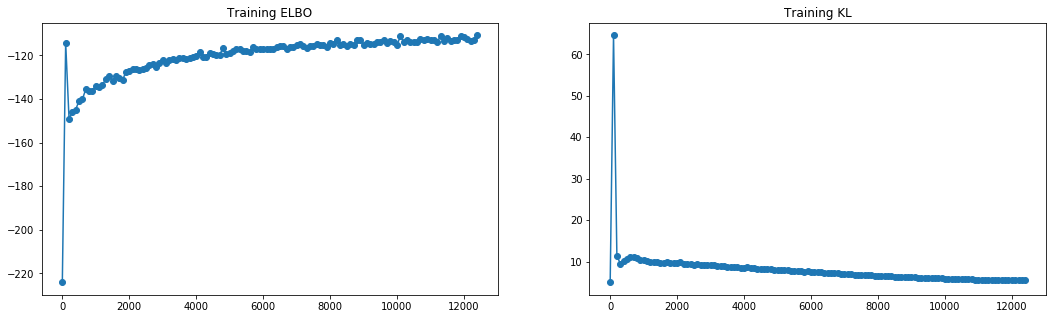

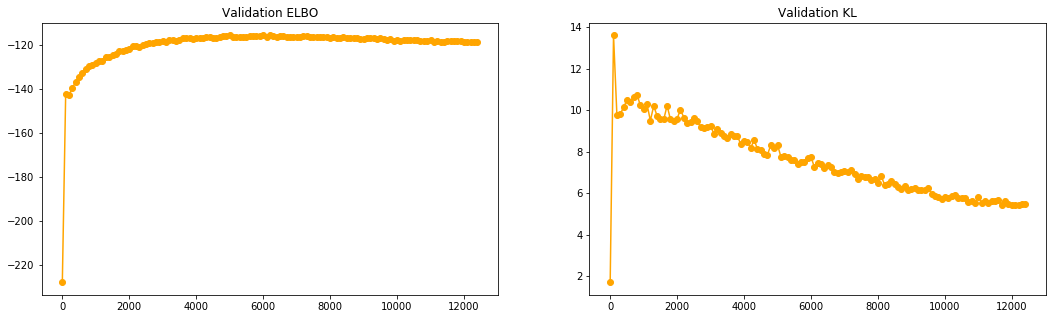

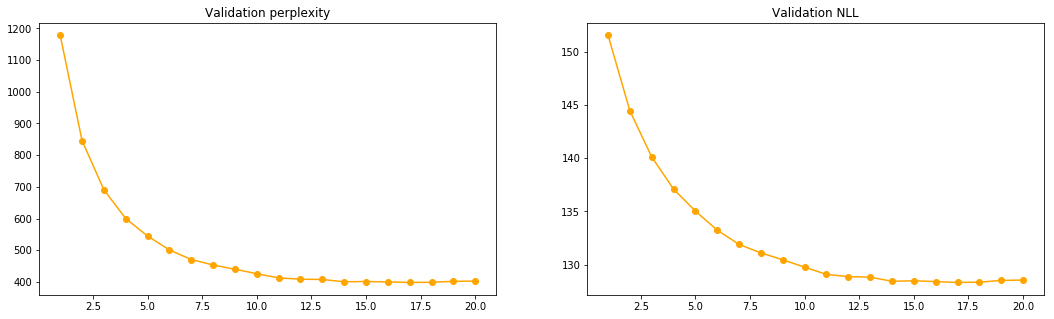

In [20]:
steps, training_ELBO = list(zip(*train_ELBOs))
_, training_KL = list(zip(*train_KLs))
_, val_ELBO = list(zip(*val_ELBOs))
_, val_KL = list(zip(*val_KLs))
epochs, val_ppl = list(zip(*val_perplexities))
_, val_NLL = list(zip(*val_NLLs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot training ELBO and KL
ax1.set_title("Training ELBO")
ax1.plot(steps, training_ELBO, "-o")
ax2.set_title("Training KL")
ax2.plot(steps, training_KL, "-o")
plt.show()

# Plot validation ELBO and KL
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.set_title("Validation ELBO")
ax1.plot(steps, val_ELBO, "-o", color="orange")
ax2.set_title("Validation KL")
ax2.plot(steps, val_KL, "-o",  color="orange")
plt.show()

# Plot validation perplexities.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.set_title("Validation perplexity")
ax1.plot(epochs, val_ppl, "-o", color="orange")
ax2.set_title("Validation NLL")
ax2.plot(epochs, val_NLL, "-o",  color="orange")
plt.show()
print()

Let's load the best model according to validation perplexity and compute its perplexity on the test data:

In [21]:
# Load the best model from disk.
model = BowmanLM(vocab_size=vocab.size(), 
                 emb_size=emb_size, 
                 hidden_size=hidden_size, 
                 latent_size=latent_size, 
                 pad_idx=vocab[PAD_TOKEN],
                 dropout=dropout,
                 bidirectional=bidirectional_encoder)
model.load_state_dict(torch.load(best_model))
model = model.to(device)

# Compute test perplexity and ELBO.
test_perplexity, test_NLL = eval_perplexity(model, test_dataset, vocab, 
                                            device, n_importance_samples)
test_rec_loss, test_KL = eval_elbo(model, test_dataset, vocab, device)
test_ELBO = test_rec_loss - test_KL
print("test ELBO (KL) = %.2f (%.2f) -- test perplexity = %.2f -- test NLL = %.2f" % 
      (test_ELBO, test_KL, test_perplexity, test_NLL))

test ELBO (KL) = 117.37 (5.55) -- test perplexity = 410.16 -- test NLL = 127.64


# Qualitative analysis

Let's have a look at what how our trained model interacts with the learned latent space. First let's greedily decode some samples from the prior to assess the diversity of the model:

In [25]:
# Generate 10 samples from the standard normal prior.
num_prior_samples = 10
pz = Normal(torch.zeros(num_prior_samples, latent_size), 
            torch.ones(num_prior_samples, latent_size))
z = pz.sample()
z = z.to(device)

# Use the greedy decoding algorithm to generate sentences.
predictions = greedy_decode(model, z, vocab)
predictions = batch_to_sentences(predictions, vocab)
for num, prediction in enumerate(predictions):
    print("%d: %s" % (num+1, prediction))

1: It was n't disclosed that the company 's stock
2: Most analysts say they are n't disclosed
3: What is n't a good
4: The Senate Majority Leader Robert M. R. D. Hart who has been a good veto of the U.S. and the Senate of the U.S. and the U.S. and chief executive officer of the company 's largest division
5: Ford 's largest maker of the company 's largest maker of the company 's largest steelmaker of the company 's largest business
6: They are n't going to be a lot of the market 's new business
7: There are n't going to be a lot of the same time to the U.S. and the best of the country
8: But they 're going to be a lot of the company
9: A spokesman said it expects to be a good bid for the company 's largest company and the company 's largest company and the company 's largest company
10: At the same time the company 's largest business and the company 's largest auto maker of the company 's largest auto maker of the company 's largest auto maker of the company 's largest auto maker of t

Let's now have a look how good the model is at reconstructing sentences from the test dataset using the approximate posterior mean and a couple of samples:

In [29]:
# Pick a random test sentence.
test_sentence = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x).
x_in, _, seq_mask, seq_len = create_batch([test_sentence], vocab, device)
qz = model.infer(x_in, seq_mask, seq_len)

# Decode using the mean.
z_mean = qz.mean
mean_reconstruction = greedy_decode(model, z_mean, vocab)
mean_reconstruction = batch_to_sentences(mean_reconstruction, vocab)[0]

print("Original: \"%s\"" % test_sentence)
print("Posterior mean reconstruction: \"%s\"" % mean_reconstruction)

# Decode a couple of samples from the approximate posterior.
for s in range(3):
    z = qz.sample()
    sample_reconstruction = greedy_decode(model, z, vocab)
    sample_reconstruction = batch_to_sentences(sample_reconstruction, vocab)[0]
    print("Posterior sample reconstruction (%d): \"%s\"" % (s+1, sample_reconstruction))

Original: "Rated Baa-1 by Moody 's and triple-B-plus by S&P the issue will be sold through underwriters led by Morgan Stanley & Co"
Posterior mean reconstruction: "Rated single-A-2 by Moody 's Investors Service Inc. said it expects to sell the company 's largest company said"
Posterior sample reconstruction (1): "Typical rates are expected to be sold by the company 's largest company and the company 's largest company"
Posterior sample reconstruction (2): "Rated single-A-2 by Moody 's Investors Service Inc. said it expects to sell the company 's stock market"
Posterior sample reconstruction (3): "Rated single-A-2 by Moody 's Investors Service Inc. said it expects to sell the company 's largest company said"


We can also qualitatively assess the smoothness of the learned latent space by interpolating between two sentences in the test set:

In [37]:
# Pick a random test sentence.
test_sentence_1 = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x).
x_in, _, seq_mask, seq_len = create_batch([test_sentence_1], vocab, device)
qz = model.infer(x_in, seq_mask, seq_len)
qz_1 = qz.mean

# Pick a random second test sentence.
test_sentence_2 = test_dataset[np.random.choice(len(test_dataset))]

# Infer q(z|x) again.
x_in, _, seq_mask, seq_len = create_batch([test_sentence_2], vocab, device)
qz = model.infer(x_in, seq_mask, seq_len)
qz_2 = qz.mean

# Now interpolate between the two means and generate sentences between those.
num_sentences = 5
print("Sentence 1: \"%s\"" % test_sentence_1)
for alpha in np.linspace(start=0., stop=1., num=num_sentences):
    z = (1-alpha) * qz_1 + alpha * qz_2
    reconstruction = greedy_decode(model, z, vocab)
    reconstruction = batch_to_sentences(reconstruction, vocab)[0]
    print("(1-%.2f) * qz1.mean + %.2f qz2.mean: \"%s\"" % (alpha, alpha, reconstruction))
print("Sentence 2: \"%s\"" % test_sentence_2)

Sentence 1: "And the facts as found by the various courts in these two lawsuits were different"
(1-0.00) * qz1.mean + 0.00 qz2.mean: "And the company 's biggest business is n't likely to be a good"
(1-0.25) * qz1.mean + 0.25 qz2.mean: "And the company 's biggest business is n't likely to be a good"
(1-0.50) * qz1.mean + 0.50 qz2.mean: "If the market is n't likely to be a lot of the company"
(1-0.75) * qz1.mean + 0.75 qz2.mean: "There are n't going to be a lot of the market"
(1-1.00) * qz1.mean + 1.00 qz2.mean: "There is a lot of the market 's decision to be a good"
Sentence 2: "There is nothing wrong with the economy all the indices are up"
